## Learning MNIST with a Multi-Layer Perceptron

First, let's download the data set.

In [2]:
!wget http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz
!wget http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz
!gzip -d train*.gz t10k*.gz

--2018-11-01 12:33:30--  http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9912422 (9.5M) [application/x-gzip]
Saving to: ‘train-images-idx3-ubyte.gz’

train-images-idx3-u 100%[===================>]   9.45M  61.1MB/s    in 0.2s    

2018-11-01 12:33:31 (61.1 MB/s) - ‘train-images-idx3-ubyte.gz’ saved [9912422/9912422]

--2018-11-01 12:33:31--  http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz
Resolving yann.lecun.com (yann.lecun.com)... 216.165.22.6
Connecting to yann.lecun.com (yann.lecun.com)|216.165.22.6|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28881 (28K) [application/x-gzip]
Saving to: ‘train-labels-idx1-ubyte.gz’

train-labels-idx1-u 100%[===================>]  28.20K  --.-KB/s    in 0.01s   

2018-11-01 12:33:31 (2.03 MB/s) - ‘train-labels-i

In [3]:
import mxnet as mx
import logging
import os

In [4]:
logging.basicConfig(level=logging.INFO)

nb_epochs=50

MXNet provides a convenient iterator for MNIST. We use it to build the training and the validation iterators.

In [5]:
train_iter = mx.io.MNISTIter(shuffle=True)
val_iter = mx.io.MNISTIter(image="./t10k-images-idx3-ubyte", label="./t10k-labels-idx1-ubyte")

We build a Multi-Layer Perceptron:
- an input layer receiving a flattened MNIST image (28x28 --> 784),
- a fully connected hidden layer with 512 neurons activated by the ReLU function,
- a dropout layer to prevent overfitting,
- a second fully connected hidden layer with 256 neurons activated by the ReLU function,
- a second dropout layer to prevent overfitting,
- an output layer with 10 neurons (because we have 10 categories), holding probabilities computed by the SoftMax function.

In [6]:
data = mx.sym.Variable('data')
data = mx.sym.Flatten(data=data)
fc1  = mx.sym.FullyConnected(data=data, name='fc1', num_hidden=512)
act1 = mx.sym.Activation(data=fc1, name='relu1', act_type="relu")
drop1= mx.sym.Dropout(data=act1,p=0.2)
fc2  = mx.sym.FullyConnected(data=drop1, name='fc2', num_hidden = 256)
act2 = mx.sym.Activation(data=fc2, name='relu2', act_type="relu")
drop2= mx.sym.Dropout(data=act2,p=0.2)
fc3  = mx.sym.FullyConnected(data=drop2, name='fc3', num_hidden=10)
mlp  = mx.sym.SoftmaxOutput(data=fc3, name='softmax')

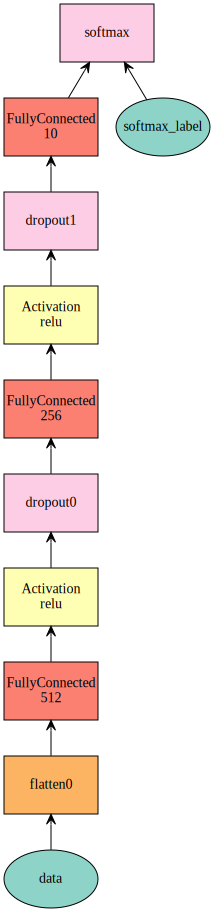

In [24]:
mx.viz.plot_network(mlp)

Now, we need to:
- bind the model to the training set,
- initialize the parameters, i.e. set initial values for all weights,
- pick an optimizer and a learning rate, to adjust weights during backpropagation

In [18]:
mod = mx.mod.Module(mlp, context=mx.gpu(0))
mod.bind(data_shapes=train_iter.provide_data, label_shapes=train_iter.provide_label)
mod.init_params(initializer=mx.init.Xavier())
#mod.init_params()
#mod.init_optimizer('sgd', optimizer_params=(('learning_rate', 0.01),))
mod.init_optimizer('adam', optimizer_params=(('learning_rate', 0.1),))
#mod.init_optimizer('adam')

Time to train!

In [19]:
mod.fit(train_iter, eval_data=val_iter, num_epoch=nb_epochs,
        batch_end_callback=mx.callback.Speedometer(128, 100))

/home/ec2-user/anaconda3/envs/mxnet_p36/lib/python3.6/site-packages/mxnet/module/base_module.py:464: UserWarning: Parameters already initialized and force_init=False. init_params call ignored.
  allow_missing=allow_missing, force_init=force_init)
INFO:root:Epoch[0] Batch [100]	Speed: 122075.77 samples/sec	accuracy=0.756652
INFO:root:Epoch[0] Batch [200]	Speed: 142985.22 samples/sec	accuracy=0.877578
INFO:root:Epoch[0] Batch [300]	Speed: 135540.95 samples/sec	accuracy=0.896016
INFO:root:Epoch[0] Batch [400]	Speed: 140535.87 samples/sec	accuracy=0.913281
INFO:root:Epoch[0] Train-accuracy=0.914879
INFO:root:Epoch[0] Time cost=0.452
INFO:root:Epoch[0] Validation-accuracy=0.938702
INFO:root:Epoch[1] Batch [100]	Speed: 122747.86 samples/sec	accuracy=0.929069
INFO:root:Epoch[1] Batch [200]	Speed: 122282.08 samples/sec	accuracy=0.930469
INFO:root:Epoch[1] Batch [300]	Speed: 149248.96 samples/sec	accuracy=0.936875
INFO:root:Epoch[1] Batch [400]	Speed: 147906.47 samples/sec	accuracy=0.942734
INF

INFO:root:Epoch[17] Time cost=0.454
INFO:root:Epoch[17] Validation-accuracy=0.981170
INFO:root:Epoch[18] Batch [100]	Speed: 130663.04 samples/sec	accuracy=0.990873
INFO:root:Epoch[18] Batch [200]	Speed: 126549.16 samples/sec	accuracy=0.988984
INFO:root:Epoch[18] Batch [300]	Speed: 112506.03 samples/sec	accuracy=0.990000
INFO:root:Epoch[18] Batch [400]	Speed: 131817.01 samples/sec	accuracy=0.991250
INFO:root:Epoch[18] Train-accuracy=0.991604
INFO:root:Epoch[18] Time cost=0.481
INFO:root:Epoch[18] Validation-accuracy=0.981070
INFO:root:Epoch[19] Batch [100]	Speed: 114582.57 samples/sec	accuracy=0.991337
INFO:root:Epoch[19] Batch [200]	Speed: 121010.90 samples/sec	accuracy=0.989688
INFO:root:Epoch[19] Batch [300]	Speed: 123608.70 samples/sec	accuracy=0.990781
INFO:root:Epoch[19] Batch [400]	Speed: 125339.61 samples/sec	accuracy=0.991484
INFO:root:Epoch[19] Train-accuracy=0.990089
INFO:root:Epoch[19] Time cost=0.491
INFO:root:Epoch[19] Validation-accuracy=0.982272
INFO:root:Epoch[20] Batch

INFO:root:Epoch[36] Batch [300]	Speed: 140332.36 samples/sec	accuracy=0.996797
INFO:root:Epoch[36] Batch [400]	Speed: 145277.72 samples/sec	accuracy=0.996094
INFO:root:Epoch[36] Train-accuracy=0.996618
INFO:root:Epoch[36] Time cost=0.439
INFO:root:Epoch[36] Validation-accuracy=0.982272
INFO:root:Epoch[37] Batch [100]	Speed: 131348.74 samples/sec	accuracy=0.996751
INFO:root:Epoch[37] Batch [200]	Speed: 140238.52 samples/sec	accuracy=0.996719
INFO:root:Epoch[37] Batch [300]	Speed: 140510.49 samples/sec	accuracy=0.996719
INFO:root:Epoch[37] Batch [400]	Speed: 128558.27 samples/sec	accuracy=0.996719
INFO:root:Epoch[37] Train-accuracy=0.996035
INFO:root:Epoch[37] Time cost=0.448
INFO:root:Epoch[37] Validation-accuracy=0.982572
INFO:root:Epoch[38] Batch [100]	Speed: 138614.94 samples/sec	accuracy=0.997447
INFO:root:Epoch[38] Batch [200]	Speed: 139597.83 samples/sec	accuracy=0.995938
INFO:root:Epoch[38] Batch [300]	Speed: 139106.99 samples/sec	accuracy=0.997422
INFO:root:Epoch[38] Batch [400]

In [20]:
mod.save_checkpoint("mlp", nb_epochs)

INFO:root:Saved checkpoint to "mlp-0050.params"


Let's measure validation accuracy.

In [21]:
metric = mx.metric.Accuracy()
mod.score(val_iter, metric)
print(metric.get())

('accuracy', 0.98387419871794868)
